# Семинар 10: Методы решения ОДУ/СДУ

**Автор: Оганов Александр**

В этом ноутбуке мы познакомимся с разными методами генерации изображений на практике. В частности разберем основу в виде генерации предложенной в статье `DDIM` [[1]](https://arxiv.org/abs/2010.02502) и с развитием идеи в походе `DPM-Solver` [[2]](https://github.com/LuChengTHU/dpm-solver) [[3]](https://arxiv.org/abs/2206.00927) [[4]](https://arxiv.org/abs/2211.01095)

# Переход от VE-SDE к VP-SDE

В прошлом ноутбуке мы обучили хоршую диффузионную модель в параметризации денойзера. К сожалению, мы использовали VE вариант зашумления, а большинство солверов придумывали для VP представления.

$$
\begin{align}
&\text{VP:} \quad \mathrm{d} \mathbf{X}_t = -\frac{1}{2} \beta(t) \mathbf{X}_t \, \mathrm{d}t + \sqrt{\beta(t)} \, \mathrm{d} \mathbf{W}_t\\
&\text{VE:} \quad \mathrm{d} \mathbf{Y}_t = g(t)\, \mathrm{d} \mathbf{W}_t\\
\end{align}
$$

Воспользуемся первым столбиком из Table 1 из статьи EDM [[5]](https://arxiv.org/abs/2206.00364) и определением денойзера для произвольного процесса зашумелния, а именно:

$$
\text{D}^{\theta}_{VP}(\mathbf{x}_t, t) = \text{D}^{\theta}_{VE}(\frac{\mathbf{x}_t}{s(t)} , \sigma(t))
$$

Мы пользуемся тем, что связь между $t$ и $sigma$ взаимоднозначная, при этом:

$$
s(t) = \sqrt{\bar{\alpha}_t} \quad \sigma(t) = \sqrt{\frac{1 - \bar{\alpha}_t}{\bar{\alpha}_t}}
$$

$$
\bar{\alpha}_t = \exp\bigg( -\int_0^t \beta(s) \mathrm{d} s \bigg)
$$

# Иференс диффузии

Мы будем брать готовые чекпоинты из статьи EDM


In [1]:
import os

if not os.path.exists("./edm"):
    !git clone https://github.com/NVlabs/edm/ edm
        
%cd edm

/home/alexandr/Документы/spec_course/edm


In [2]:
import pickle
import torch

import dnnlib

In [3]:
def load_edm_net(
    network_pkl = "https://nvlabs-fi-cdn.nvidia.com/edm/pretrained/edm-cifar10-32x32-uncond-vp.pkl"
    ):

    with dnnlib.util.open_url(network_pkl, verbose=1) as f:
        net = pickle.load(f)['ema']

    for param in net.parameters():
        param.requires_grad = False

    net.eval()
    net.cuda()
    return net

In [4]:
class VPScheduler:

    def __init__(self):
        beta_min = 0.1
        beta_d   = 19.9

        self.vp_sigma   = lambda t: (torch.exp(0.5 * beta_d * (t ** 2) + beta_min * t) - 1) ** 0.5
        self.s          = lambda t: torch.exp(-1./2. * (0.5 * beta_d * (t ** 2) + beta_min * t))

def predict_x0_VP_SDE(net, scheduler):

    def diff_x0_fn(x, t):

        # https://arxiv.org/abs/2206.00364
        # table 1, column 1
        s = scheduler.s(t)[:, None, None, None]
        sigma = scheduler.vp_sigma(t)[:, None, None, None]

        return net(x / s, sigma)

    return diff_x0_fn

In [5]:
model = load_edm_net()

In [6]:
scheduler = VPScheduler()
model_fn_x0 = predict_x0_VP_SDE(net=model, scheduler=scheduler)

Чаще всего нам потребуется предсказывать не $\mathbf{X}_0$, а $ \varepsilon $ (предсказывать шум). Мы могли бы воспользоваться знаниями про VP-SDE и записать:


$$
\mathbf{X}_t = \sqrt{\bar{\alpha}_t} \mathbf{X}_0 + \sqrt{1 - \bar{\alpha}_t} \varepsilon\\
$$
$$
\varepsilon = \frac{\mathbf{X}_t - \sqrt{\bar{\alpha}_t} \mathbf{X}_0}{\sqrt{1 - \bar{\alpha}_t}}
$$

# Генерация с помощью DDIM

Самым базовым и первым подходом к генерации изображений за произвольное число шагов является метод предложенный в работе `DDIM` еще для дискретных моделей.

$$
\begin{align}
\mathbf{X}_{t-1} & = \sqrt{\bar\alpha_{t-1}} \underbrace{\left(\frac{\mathbf{X}_t - \sqrt{1 - \bar\alpha_t} \epsilon_\theta^{(t)}(\mathbf{X}_t)}{\sqrt{\bar\alpha_t}}\right)}_{\text{`` predicted } x_0 \text{''}} + \underbrace{\sqrt{1 - \bar\alpha_{t-1} - \sigma_t^2} \cdot \epsilon_\theta^{(t)}(\mathbf{X}_t)}_{\text{``direction pointing to } \mathbf{X}_t \text{''}} + \underbrace{\sigma_t \epsilon_t}_{\text{random noise}}\\
\sigma_t & = \eta \sqrt{\frac{1 - \bar\alpha_{t-1}}{1 - \bar\alpha_t}} \sqrt{1 - \frac{\bar\alpha_t}{ \bar\alpha_{t-1}}}
\end{align}
$$
Подробный вывод можно встретить в статье.

In [7]:
@torch.no_grad()
def gen_ddim_solver(latents, timesteps, model_fn, eta=0):
    # source https://github.com/ermongroup/ddim/blob/e8df66cf02e457719930748b5c26e37e3126dfdd/functions/denoising.py#L10
    # eta = 0 is ODE
    # eta
    # model_fn predict x_0
    
    scheduler = VPScheduler()
    x0_preds = []
    xs = [latents]
    for t, next_t in zip(timesteps[:-1], timesteps[1:]):

        at = scheduler.s(t) ** 2
        at_next = scheduler.s(next_t) ** 2
        xt = xs[-1].to('cuda')
        
        x0_t = model_fn(xt, t[None])
        et = (xt - x0_t * at.sqrt()) / (1 - at).sqrt() 
        
        x0_preds.append(x0_t.to('cpu'))
        c1 = (
            eta * ((1 - at / at_next) * (1 - at_next) / (1 - at)).sqrt()
        )
        c2 = ((1 - at_next) - c1 ** 2).sqrt()
        xt_next = at_next.sqrt() * x0_t + c1 * torch.randn_like(latents) + c2 * et
        xs.append(xt_next.to('cpu'))

    return xs[-1]


In [8]:
import matplotlib.pyplot as plt

from torchvision.utils import make_grid


def remove_ticks(ax):
    ax.tick_params(
        axis='both',
        which='both',
        bottom=False,
        top=False,
        labelbottom=False,
        left=False,
        labelleft=False
    )

def vis_img(img_tensor, ax):
    
    img_grid = make_grid(img_tensor, 4, 4)
    
    images_np = (img_grid * 127.5 + 128).clip(0, 255).to(torch.uint8).permute(1, 2, 0).cpu().numpy()
    
    ax.imshow(images_np)
    remove_ticks(ax)

Важным параметром для нас является параметр number of function evaluations (NFE) -  число вызов нейронной сети.
Будем рассматривать `NFE = 10`

In [9]:
NFE = 10
eps = 1e-4
timesteps = torch.linspace(1., eps, NFE + 1).cuda()
timesteps

tensor([1.0000e+00, 9.0001e-01, 8.0002e-01, 7.0003e-01, 6.0004e-01, 5.0005e-01,
        4.0006e-01, 3.0007e-01, 2.0008e-01, 1.0009e-01, 1.0000e-04],
       device='cuda:0')

In [10]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

latents = torch.randn((16, 3, 32, 32)).cuda()

In [11]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

out_det = gen_ddim_solver(
    latents,
    timesteps=timesteps,
    model_fn=model_fn_x0,
    eta=0
)

In [12]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

out_stoch = gen_ddim_solver(
    latents,
    timesteps=timesteps,
    model_fn=model_fn_x0,
    eta=1
)

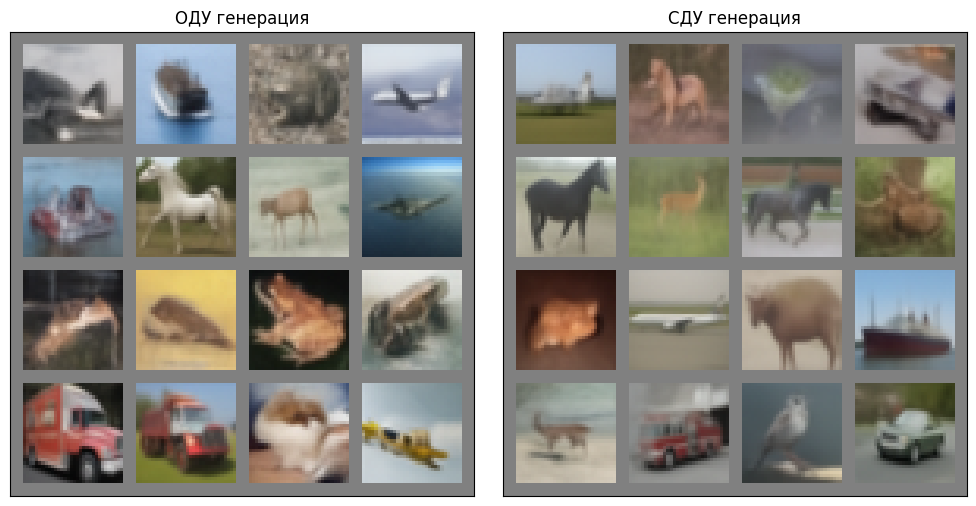

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].set_title("ОДУ генерация")
vis_img(out_det, ax[0])

ax[1].set_title("СДУ генерация")
vis_img(out_stoch, ax[1])

plt.tight_layout()
plt.show()

Сложно сказать визуально, какая генерация лучше. Однако версия с СДУ, кажется более размытый. Если померить FID, то выйдут примерно следующие цифры

`FID ODE ~ 16` 

`FID SDE ~ 55`

# Генерация с помощью DPM-Solver

`DPM-Solver` - современный солвер для решения ОДУ с VP зашумления.

Подробный вывод можно встретить в статье, либо в материалах лекции.

In [14]:
%cd ..

/home/alexandr/Документы/spec_course


In [15]:
if not os.path.exists("./dpm-solver"):
    !git clone https://github.com/LuChengTHU/dpm-solver.git
        
%cd dpm-solver

/home/alexandr/Документы/spec_course/dpm-solver


Будем следовать официальной документации, благо она достаточно простая и приятная

In [16]:
from dpm_solver_pytorch import NoiseScheduleVP, DPM_Solver, model_wrapper

In [17]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

noise_schedule = NoiseScheduleVP('linear') # \beta(t) = 20 t + 0.01
model_fn = model_wrapper(
    model_fn_x0,
    noise_schedule=noise_schedule,
    model_type="x_start", #"x_start"
)


solver = DPM_Solver(
    model_fn=model_fn, 
    noise_schedule=noise_schedule, 
    algorithm_type='dpmsolver++'
)

Для начала проверим методы первого порядка: `order = 1`

В качестве расписания времени будем использовать 2 стандартных:

* Равномерное

* LogSNR

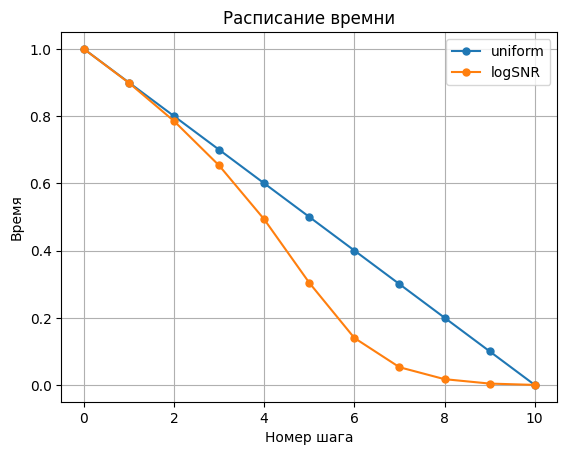

In [18]:
t_uniform = solver.get_time_steps('time_uniform', 1, 1e-3, 10, 'cpu').numpy()
t_logSNR  = solver.get_time_steps('logSNR', 1, 1e-3, 10, 'cpu').numpy()

plt.plot(t_uniform, label='uniform', marker='.', markersize=10)
plt.plot(t_logSNR, label='logSNR', marker='.', markersize=10)


plt.title("Расписание времни")
plt.xlabel("Номер шага")
plt.ylabel("Время")
plt.legend()
plt.grid()
plt.show()

In [19]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

sample_1S_unif = solver.sample(
   x=latents,
   steps=NFE,
   order=1,
   skip_type='time_uniform',
   method='singlestep',
)
sample_1S_unif = sample_1S_unif.to('cpu')



In [20]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

sample_1S_logSNR = solver.sample(
   x=latents,
   steps=NFE,
   order=1,
   skip_type='logSNR',
   method='singlestep',
)
sample_1S_logSNR = sample_1S_logSNR.to('cpu')

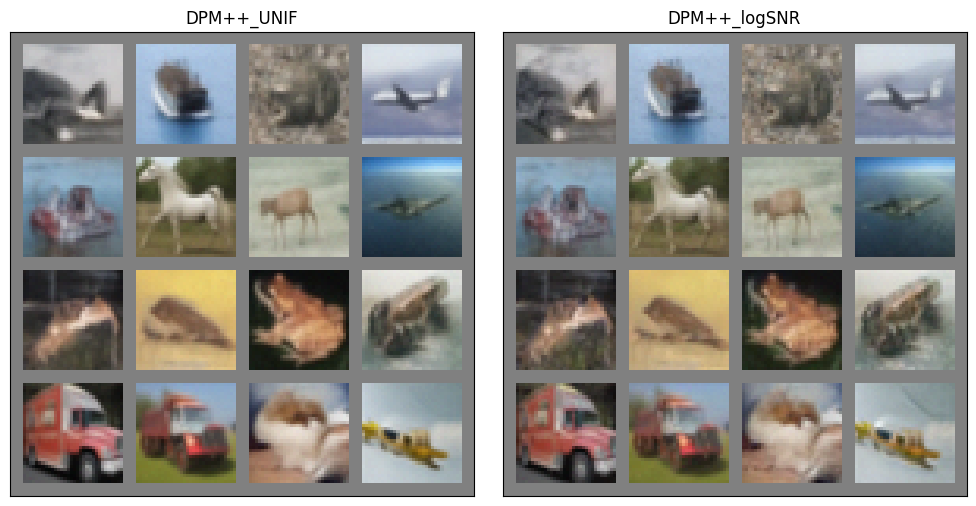

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].set_title("DPM++_UNIF")
vis_img(sample_1S_unif, ax[0])

ax[1].set_title("DPM++_logSNR")
vis_img(sample_1S_logSNR, ax[1])

plt.tight_layout()
plt.show()

В целом, результаты при использовании метода первого порядка должны быть сравнимы с `DDIM`. Визуально генерация стала чуть лучше, попробуем теперь использовать методы второго порядка `order = 2`

In [22]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

sample_2M_unif = solver.sample(
   x=latents,
   steps=NFE,
   order=2,
   skip_type='time_uniform',
   method='multistep',
)
sample_2M_unif = sample_2M_unif.to('cpu')

In [23]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

sample_2M_logSNR = solver.sample(
   x=latents,
   steps=NFE,
   order=2,
   skip_type='logSNR',
   method='multistep',
)
sample_2M_logSNR = sample_2M_logSNR.to('cpu')

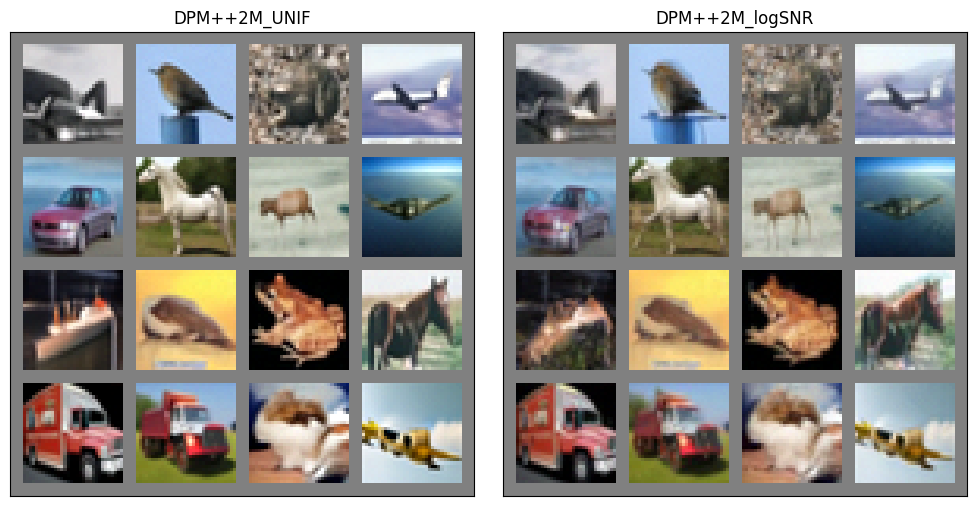

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].set_title("DPM++2M_UNIF")
vis_img(sample_2M_unif, ax[0])

ax[1].set_title("DPM++2M_logSNR")
vis_img(sample_2M_logSNR, ax[1])

plt.tight_layout()
plt.show()

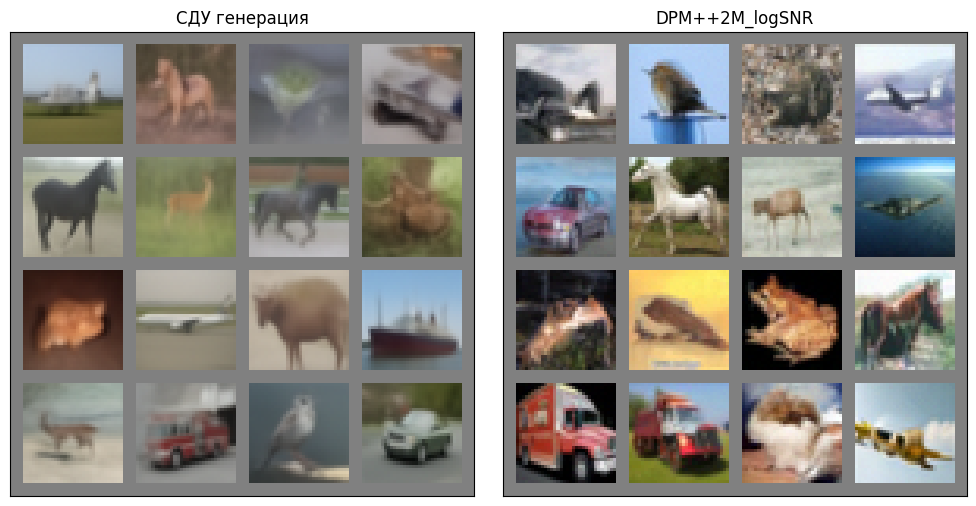

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].set_title("СДУ генерация")
vis_img(out_stoch, ax[0])

ax[1].set_title("DPM++2M_logSNR")
vis_img(sample_2M_logSNR, ax[1])

plt.tight_layout()
plt.show()

При использовании методов второго порядка даже визуально получается увидеть разницу. Если же посчитать FID, то при генерации с помощью `DPM-Solver++(2M)` с `logSNR` расписанием будет `FID ~ 4.9` при `10 шагах`.